In [1]:
import sys 
sys.path.append('/home/goetzl/ETH/NeuralPlanes')

In [2]:
print(sys.path)
from NeuralPlanes.localization.map import NeuralMap, NeuralMapConf
from NeuralPlanes.localization.pose_scoring import score_pose
from NeuralPlanes.pipeline.lamar import *
from NeuralPlanes.pipeline.dataloader import *
from NeuralPlanes.plane import Planes 
from NeuralPlanes.utils import select_device
from matplotlib import pyplot as plt 
import umap

['/home/goetzl/ETH/NeuralPlanes/NeuralPlanes/pipeline', '/home/goetzl/ETH/NeuralPlanes/NeuralPlanes/pipeline/$PYTHONPATH', '/home/goetzl/ETH/NeuralPlanes/NeuralPlanes/pipeline/~/ETH/NeuralPlanes', '/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python311.zip', '/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11', '/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/lib-dynload', '', '/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/site-packages', '/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/site-packages/tinycudann-1.7-py3.11-linux-x86_64.egg', '/home/goetzl/ETH/NeuralPlanes']


In [3]:
device = select_device()

In [4]:
lamar_path = Path("../../data/HGE/HGE")

session_map_path = lamar_path / "sessions" / "map"
session_map_image_path = session_map_path / "raw_data"
session_map_path_precompute = lamar_path / "sessions" / "map_precompute_256"
session_map_path_depth = session_map_path_precompute / "depth"
session_map_path_embedding = session_map_path_precompute / "embedding"

images_raw = parse_session(session_map_path, lambda path: path.startswith("ios"))

print("Map images ", len(images_raw))

floor_plan_img, plane_points, floorplan_to_world = parse_floorplan(lamar_path / "floor_plan")

Map images  7553


/home/goetzl/ETH/NeuralPlanes/NeuralPlanes/pipeline/lamar.py:300: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  normal = torch.cross(x1-x0, x2-x1)


Using cache found in /home/goetzl/.cache/torch/hub/yvanyin_metric3d_main
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1920, 1440)


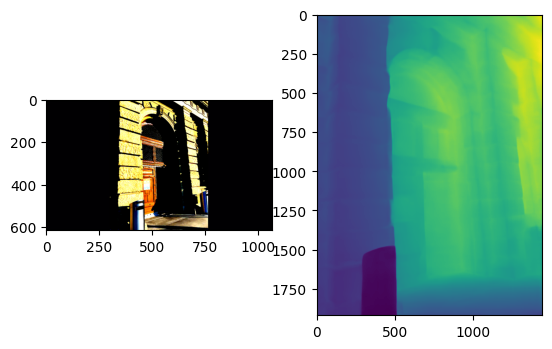

In [12]:
image = images_raw[600]
model = MonocularDepthModel()
model = model.to(device)

data = collate_fn(compose([model.preprocess]))([image])

data = {k: v.to(device) if isinstance(v,torch.Tensor) else v for k,v in data.items()}

result = model(data)
depth = result["image"][0].detach().cpu().numpy()
print(depth.shape)

fig, axs = plt.subplots(1,2)
axs[0].imshow(data["rgb"][0].detach().cpu().permute(1,2,0))
axs[1].imshow(depth)


In [6]:
max_size = 256
cameras = []

pre = Images(images=[], by_path={}, base_path=session_map_path_depth)

for image in tqdm.tqdm(images_raw):
    path = image.path
    new_path = str(Path(path).with_suffix(".tif"))

    depth = io.imread(str(session_map_path_depth / new_path))
    max_depth = depth.max()

    camera = image.camera.scale(min(1.0, max_size / max(image.camera.size)))
    camera.far = min(max_depth, 15)

    #print("Max depth ", max_depth, camera.far, new_path, "dtype= ", depth.dtype, "depth= ", depth.shape, "camera=", camera.size)
    image.camera = camera

    meta = copy.copy(image)
    meta.path = new_path

    cameras.append(camera)
    pre.images.append(meta)
    pre.by_path[path] = meta

images = copy.copy(pre)
images.base_path = session_map_path_embedding

depths = copy.copy(pre)
depths.base_path = session_map_path_depth

100%|██████████| 7553/7553 [00:04<00:00, 1862.78it/s]


In [7]:
model_checkpoint = "checkpoint/model.pt"

conf = NeuralMapConf(num_components=4, num_features_backbone=21, num_features=16)
height, width = 1336, 899
n_planes = 73
n_comp = 4
n_feat = 16
map = NeuralMap(planes=Planes(x0s=torch.zeros((n_planes,3),device=device),
                                us=torch.zeros((n_planes,3),device=device), 
                                vs=torch.zeros((n_planes,3),device=device), 
                                planes=torch.zeros((n_planes,4)), 
                                coord_x0=torch.zeros((n_planes,2)), 
                                coord_size=torch.zeros((n_planes,2)), 
                                atlas_size=[width, height]), 
                    atlas_alpha=torch.zeros((n_comp,height,width), device=device), 
                    atlas_mu=torch.zeros((n_comp, n_feat, height, width),device=device), 
                    atlas_var=torch.zeros((n_comp, n_feat, height, width),device=device), 
                    atlas_weight=torch.zeros((height, width),device=device), conf=conf)
map.load_state_dict(torch.load(model_checkpoint), strict=False)

KeyboardInterrupt: 

torch.Size([21, 512, 384]) torch.Size([512, 384]) tensor(0.0512) tensor(29.9688)


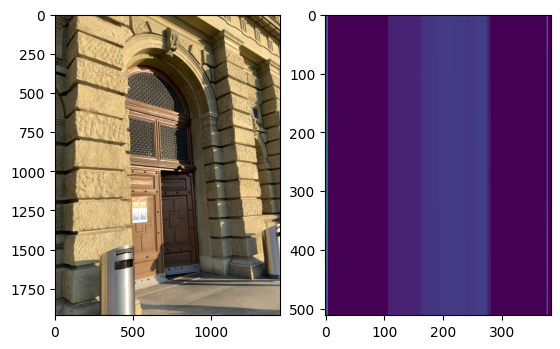

In [ ]:
idx = 600
accesses = [idx]

dataloader_conf = DataloaderConf()

raw_image_loader = SequentialLoader(images_raw, accesses=accesses, conf=dataloader_conf, collate_fn=lambda x: x)
image_loader = SequentialLoader(images, accesses=accesses, conf=dataloader_conf, collate_fn=collate_fn(lambda x: {"image": torch.tensor(x["image"].reshape(x["image"].shape[0], x["image"].shape[1]//7, 21), dtype=torch.float).permute(2,0,1)}))
depth_loader = SequentialLoader(depths, accesses=accesses, conf=dataloader_conf, collate_fn=collate_fn(lambda x: {"image": torch.tensor(x["image"][:,:,0], dtype=torch.float)}))

raw = raw_image_loader[idx]['image']
image = image_loader[idx]['image']
depth = depth_loader[idx]['image']

print(image.shape, depth.shape, depth.min(), depth.max())

fig, ax = plt.subplots(1,2)
ax[0].imshow(raw)
ax[1].imshow(depth) #torch.minimum(depth, torch.tensor(2.)))


In [ ]:
c,height,width = image.shape
features = map.encoder(image.to(device).permute(1, 2, 0).reshape(height * width, c))
features = features.reshape(height, width, conf.num_features).permute(2, 0, 1)

print(features.mean(dim=2).mean(dim=1))

feat_np = features.permute(1,2,0).detach().cpu().numpy()

mapper = umap.UMAP(n_components=3).fit(feat_np.reshape(-1,conf.num_features))


tensor([ 1.9092e-01,  3.9945e-01, -2.6393e-03, -3.6777e-03, -1.6026e-03,
        -3.9246e-03, -3.5493e-03, -7.7879e-04, -8.6759e-04, -1.4843e-03,
        -1.7795e-03, -2.7345e-04,  2.6191e-01, -2.1205e-03,  2.4764e-01,
        -2.1669e-03], device='cuda:0', grad_fn=<MeanBackward1>)


/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


KeyboardInterrupt: 

In [ ]:
mapper.embedding_.shape

(196608, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


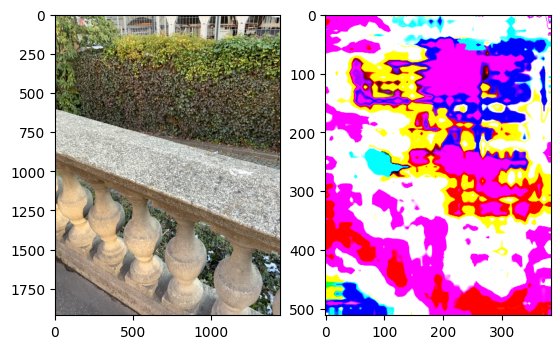

In [ ]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(raw)
axes[1].imshow(mapper.embedding_.reshape(height,width,3))

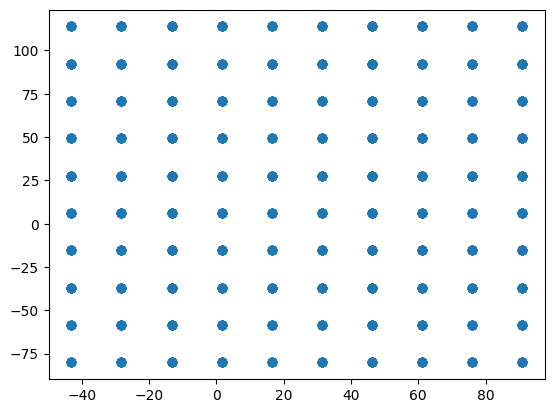

In [ ]:
planes = map.planes
x00 = planes.x0s[0] 
x01 = planes.x0s[0] + planes.us[0]
x10 = planes.x0s[0] + planes.vs[0]
x11 = planes.x0s[0] + planes.us[0] + planes.vs[0]

div = 10
xs,ys,thetas = torch.meshgrid(torch.linspace(x00[0], x01[0], div), torch.linspace(x01[1], x11[1], div), torch.linspace(0, 2*torch.pi, div)) 
xs,ys,thetas = xs.flatten(),ys.flatten(),thetas.flatten()



for x,y,theta in xs,ys,thetas:
    score_pose()

plt.scatter(x,y)

#score_pose(cam_copy, image, depth)